In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import quandl
import seaborn as sns
import math

In [2]:
all_salaries = pd.read_csv('Salaries.csv')
all_batting = pd.read_csv('Batting.csv')
all_pitching = pd.read_csv('Pitching.csv')

Populating the interactive namespace from numpy and matplotlib


LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

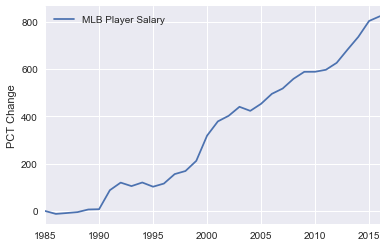

In [3]:
%pylab inline

yearly_average_salary = all_salaries.groupby('yearID').mean()
yearly_salary_pct_change = 100.0 *  (yearly_average_salary - yearly_average_salary.iloc[0]) / yearly_average_salary.iloc[0]
yearly_salary_pct_change.plot()
plt.legend(['MLB Player Salary']); plt.ylabel('PCT Change'); plt.xlabel('')
median_household_income = quandl.get('FRED/MEHOINUSA646N', start_date = '1985-01-01')
median_household_pct_change = 100.0 * (median_household_income - median_household_income.iloc[0]) / median_household_income.iloc[0]
median_household_pct_change.plot(color = 'c')
plt.legend(['Median Household Income']), plt.ylabel('PCT Change'), plt.xlabel('');

In [ ]:
salaries_2008 = all_salaries[all_salaries['yearID']==2008]
salaries_2008 = salaries_2008.drop(['yearID', 'teamID', 'lgID'], axis=1)

In [ ]:
plt.hist((salaries_2008['salary']/1e6), bins=6, color='g', edgecolor='black', linewidth=1.2, align='mid');
plt.xlabel('Salary (millions of $)'), plt.ylabel('Count')
plt.title('MLB 2008 Salary Distribution', size = 10);

In [ ]:
# Modify all_batting to contain only the statistics I want to examine
# For batting these are: Runs Batted In (RBI), Hits (H), Home Runs (HR)
# Also I only want to examine the 5 year period around the salary year [2006-2010]
years_to_examine = [2006, 2007, 2008, 2009, 2010]
batting = all_batting[['playerID', 'yearID', 'RBI', 'H', 'HR', 'G']]
batting = batting[batting['yearID'].isin(years_to_examine)]

In [ ]:
# For pitching, the relevant statistics are: Earned Run Average (ERA), Wins (W), and Stikeouts (SO)
pitching = all_pitching[['playerID', 'yearID', 'ERA', 'W', 'SO', 'IPouts']]
pitching = pitching[pitching['yearID'].isin(years_to_examine)]

In [ ]:
# Examine the data so far
print(batting.tail(10), '\n')
print(pitching.tail(10))

I noticed that some player IDs appear twice for the same year in the data. Looking at the source more closely, I saw that was because some players had multiple stints in the same season. That is, they were traded to another team and had played a full season but for different teams. I wanted to include these players in my analysis, so I grouped the data by player and year, and summed up the statistics for players who had multiple entries in the same year. 

In [ ]:
batting = batting.groupby(['playerID', 'yearID'], as_index=False).sum()
pitching = pitching.groupby(['playerID', 'yearID'], as_index=False).sum()

It looks like I have a decent start, but there are several issues with the data. Primarily, I only want to examine players who have records across all five of the years, and I want players who played a full season in each of the years. This is to exclude any players who may have been injured. After doing some research on http://www.fangraphs.com/, I decided that a decent metric to measure this would be 100 games average per season for the batting statistics and 120 innings pitched averaged for the pitchers. I decided to limit the analysis to starting pitchers and I would not look at relievers or closers.  

In [ ]:
batting = batting[batting['G'] > 100]
pitching = pitching[(pitching['IPouts'] / 3) > 120]

I now need a way to select only players who have records for all five years. I decided to write a function that could take in the batting and pitching DataFrames, and return DataFrames with only players who played in all five years. 

In [ ]:
def find_players_with_all_years(records):
    players_with_all_years = set()
    for player_ID in records['playerID']:
        years_played = []
        years_played = list(records.loc[records['playerID'] == player_ID]['yearID'])
        if years_played == years_to_examine:
            players_with_all_years.add(player_ID)
    return records[records['playerID'].isin(players_with_all_years)]

batting = find_players_with_all_years(batting)
pitching = find_players_with_all_years(pitching)

In [ ]:
player_counts = []
for playerID in batting['playerID']:
    player_counts.append(list(batting['playerID']).count(playerID))

In [ ]:
np.mean(player_counts)

In [ ]:
player_counts = []
for playerID in batting['playerID']:
    player_counts.append(list(batting['playerID']).count(playerID))

In [ ]:
np.mean(player_counts)

Given that the mean number of appearances of each player ID in the pitching and batting DataFrames was 5.0, I can be sure that my DataFrames now contain only players who meet the criteria of having played in all five seasons I am examining. They also will only contain players who meet the games played or innings pitched cut-offs for batters and pitchers respectively. I now want to create four separate DataFrames in order to make comparisons between statistics and seasons:
1. An average of statistics over the entire five seasons
2. An average of statistics over the two seasons before the salary year (2006-2007)
3. The statistics for the salary year of 2008
4. An average of statistics over the two seasons after the salary year (2009-2010)

In [ ]:
salaries_2008.rename(columns={'salary': '2008_Salary'},inplace=True)

I now want to include the salaries in the DataFrame. This will put in the same 2008 salary for all five years, which is fine at this point as the averaging will simply return the same number. 

In [ ]:
batting = batting.merge(salaries_2008, on='playerID')
batting = batting.rename(columns = {'H': 'Hits', 'HR': 'Home Runs', 'G': 'Games', '2008_Salary' : 'Salary'})

In [ ]:
pitching = pitching.merge(salaries_2008, on='playerID')
pitching = pitching.rename(columns = {'W':'Wins', 'SO':'Strikeouts', '2008_Salary': 'Salary'})

In [ ]:
previous_years = [2006, 2007]
following_years = [2009, 2010]

def create_seasons_averages(records):
    five_year_average = records.groupby('playerID', as_index=False).mean()
    
    previous_two_years = records[records['yearID'].isin(previous_years)]
    previous_two_years_average = previous_two_years.groupby('playerID', as_index=False).mean()
    
    following_two_years = records[records['yearID'].isin(following_years)]
    following_two_years_average = following_two_years.groupby('playerID', as_index=False).mean()
    
    salary_year = records[records['yearID'] == 2008]
    
    return previous_two_years_average, following_two_years_average, salary_year, five_year_average 

The function will return the four DataFrames I specified. The lines below actually create the DataFrames. 

In [ ]:
pitching_previous, pitching_following, pitching_salary_year, pitching_five_year = create_seasons_averages(pitching)

batting_previous, batting_following, batting_salary_year, batting_five_year = create_seasons_averages(batting)

The next cell provides me with the number of batters and pitchers I am dealing with who meet the criteria, as well as a sanity check to make sure that all my DataFrames turned out fine. 

In [ ]:
print('There are {} batters in the wrangled dataset.'.format(len(batting_previous)))
print(len(batting_previous)==len(batting_following)==len(batting_salary_year)==len(batting_five_year), '\n')

print('There are {} pitchers in the wrangled dataset.'.format(len(pitching_previous)))
print(len(pitching_previous)==len(pitching_following)==len(pitching_salary_year)==len(pitching_five_year))

In [ ]:
pitching_previous.head(10)

In [ ]:
batting_five_year.head(10)

As a final step, I can drop the yearID from all the DataFrames. I want to keep the playerID because I will use it to compare players statistics from prior years to the following years. I will also keep the game and innings pitched times outs statistics as they also could be analysed.

In [ ]:
df_list = [pitching_previous, pitching_following, pitching_salary_year, pitching_five_year, \
           batting_previous, batting_following, batting_salary_year, batting_five_year]

def drop_year_and_player_ID(df_list):
    for df in df_list:
        df.is_copy = False
        df.drop(['yearID'] , axis=1, inplace=True)

drop_year_and_player_ID(df_list)

In [ ]:
pitching_previous.head()

In [ ]:
batting_salary_year.head()

I finally have the data wrangled in the format I want! It's time to start the analysis. I mainly want to see if there are any statistics that are highly correlated with salary, and if these correlations might change over time. My hypotheses are:

1. Flashier stats such as home runs for batters and wins for pitchers will have the highest correlation with salary across all the years. 
2. Average statistics from the two seasons prior to the salary year will have a higher correlation with the salary than average statistics following the salary year. 
3. Players with a salary above the average will tend to improve from the previous years to the following years. 
4. Performance drives salary more than salary drives performance. In other words, if you think of the years previous to the salary as dictating the amount that the player is paid, that will have a higher correlation than the performance after the salary, which could be a measure of how much the salary affect performance. 

### First I will examine the batters, and using the five-year average, determine which statistic is most highly correlated with salary. I will then examine that statistic as it changes from the previous two seasons to the following two seasons. 

I'll start off with the five year averages.

In [ ]:
def analyze_five_year_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6
        plt.figure()
        plt.scatter(x,y)
        plt.title('Five-Year Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the five years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()[statistic]['Salary']))
        
analyze_five_year_records(batting_five_year, ['RBI', 'Hits', 'Home Runs'])

As can be seen in the plots and the Pearson's correlation coefficients, Runs Batted In has the highest correlation with salary followed by Home Runs and Hits. I also determined the correlation between games played and salary although that was low as I expected because I had already screened out players with fewer than 100 games. 

Based on this preliminary investigation, I can draw the conclusion that RBIs is the performance metric that has the highest correlation with player salary for 2008. Now, I want to look at how the correlations change from the preceding seasons to the following seasons. 

In [ ]:
def analyze_previous_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6
        plt.figure()
        plt.scatter(x,y)
        plt.title('Previous Two Seasons Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the previous two years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()['Salary'][statistic]))

In [ ]:
analyze_previous_records(batting_previous, ['RBI', 'Hits', 'Home Runs'])

Wow! The correlation between the average performance metrics from the previous two years and salary is much greater than that between the average performance metrics over the entire five years and salary. This suggests to me that performance metrics really do drive the salary. In other words, players who do well are rewarded with larger salaries. 

Next, we can look at the two seasons following the salary to see if the correlations remain. My guess is that no, the correlation between the performance metrics and the salary will drop in the following years. Players who have a large salary ,ay not have as great of an incentive to perform, and their statistics will slip. 

In [ ]:
def analyze_following_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6
        plt.figure()
        plt.scatter(x,y)
        plt.title('Following Two Seasons Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the following two years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()['Salary'][statistic]))

In [ ]:
analyze_following_records(batting_following, ['RBI', 'Hits', 'Home Runs'])

That is striking. The correlations have all decreased. In summary, here is a chart showing how the correlations between performance metrics and salary changed depending on the time span analyzed:

|                      | Previous Two Seasons | Five Season Average | Following Two Seasons |
|:--------------------:|----------------------|---------------------|-----------------------|
| RBI Correlation      |         0.462        |        0.344        |         0.200         |
| Hits Correlation     |         0.332        |        0.238        |         0.110         |
| Home Run Correlation |         0.396        |        0.299        |         0.156         |

I think what is being demonstrated here is an example of [regression to the mean](https://www.socialresearchmethods.net/kb/regrmean.php). Players perform well for two seasons, are awarded a larger contract, and then fail to live up to their earlier numbers in the following seasons. This is intriguing because it means that players are awarded larger contracts based on their past performance but are paid less in their higher performing seasons. Once they earn a large contract, their performace tends to decrease because it was an anomaly beforehand and they will tend to revert to a more average level of play. That leaves teams with a conundrum because they will end up paying more for players with lower performance. The key is to identify young players with potential who have not yet played well enough to earn a large contract, and, after they have performed highly and expect a salary increase, trade them to another team because their performance will likely decline. 

I'll perform a similar analysis of the pitching metrics before I return to the batting stats to determine whether or not players with larger than average salaries tend to perform worse in the seasons following the salary as compared to the seasons preceding the salary. 

In [ ]:
analyze_five_year_records(pitching_five_year, ['ERA', 'Wins' ,'Strikeouts'])

Right away, we can see that the correlation between ERA and salary is slightly negative as expected because a lower Earned Runs Average is better for a pitcher. We can also see that there appears to be the largest correlation between wins and salary of the three performance metrics. This is what I expected because wins are easy for everyone (especially those paying the players) to understand and it just feels "right" to award a pitcher a higher salary if they generate more wins regardless of how good an indicator of a pitchers ability wins actually are. I must offer a word of caution regarding this dataset though. The sample size of 32 is relatively small compared to the 83 samples in the batting dataset. I will go through the same process as with the batters and see if the salary correlations are greater in the preceding two seasons or the following two seasons. 

In [ ]:
analyze_previous_records(pitching_previous, ['ERA', 'Wins', 'Strikeouts'])

In [ ]:
analyze_following_records(pitching_following, ['ERA', 'Wins', 'Strikeouts'])

Regression to the mean strikes again! (No pun intended). As was demonstrated in the batting analysis, the two years preceding the salary had a much higher correlation with the salary than the two years following. In fact, wins, which were the most highly correlated over the entire five year average, had a negative correlation with 2008 salary in the following seasons. That means that the more a pitcher had been paid in 2008, the less wins he had over the next two seasons! Granted, this dataset is small, and pitching statistics can be heavily influenced by fielding and the rest of the team, but that is still a very intriguing result. Again, we see the need for identifying players before they hit their prime seasons so they can be paid less and teams can extract more performance from them at a lower price (this is capitalism after all). Once a player has reached their peak seasons, they will command a higher salary, but then their performance will tend to slip back towards the average and they should not be as highly "valued." Here is a summary of the correlations between pitching performance metrics and salary:

|                        | Previous Two Seasons | Five Season Average | Following Two Seasons |
|:----------------------:|----------------------|---------------------|-----------------------|
| ERA Correlation        |        -0.252        |        -0.127       |         -0.050        |
| Wins Correlation       |         0.473        |        0.329        |         -0.050        |
| Strikeouts Correlation |         0.288        |        0.021        |         -0.228        |



#### Z-Tests 

I wanted to perform a more rigorous statistical analysis of the performance metrics and their relation to salary. In particular, I wanted to see if players with above average salaries in 2008 had a statistically significant decrease in their performance from the previous two season (2006-2007) and the following two seasons (2009-2010). I decided to focus on one performance metric for batters, and one for pitchers. For batters, I choose RBI because it had the highest correlation with salary over the entire five year average. For pitchers, a similar reasoning applied and so I choose wins. 

I first needed to create a DataFrame of batters that contained playerIDs, the difference in the number of RBIs from the preceding season to the following season, and standardized salaries. Standardizing the salaries would allow me to see if a player had an average salary above or below the mean. 

In [ ]:
batting_previous.rename(columns={'RBI': 'RBI_prev'}, inplace=True)
batting_following.rename(columns={'RBI' :'RBI_foll'},inplace=True)
batting_comparison = batting_previous[['playerID', 'RBI_prev']]

In [ ]:
batting_comparison = batting_comparison.merge(batting_following, on='playerID')
batting_comparison.head()

In [ ]:
# Create a column showing the change in RBIs from the previous seasons to the following seasons
batting_comparison['RBI_change'] = batting_comparison['RBI_foll'] - batting_comparison['RBI_prev']

In [ ]:
batting_comparison = batting_comparison[['playerID' , 'Salary', 'RBI_change']]

In [ ]:
# Positive values for RBI_change indicate that the players RBIs increased from the previous seasons to the following seasons
batting_comparison.head()

In [ ]:
batting_comparison['Salary_SD'] = (batting_comparison['Salary'] - batting_comparison['Salary'].mean()) / batting_comparison['Salary'].std()

In [ ]:
batting_comparison.head()

In [ ]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

bins = range(-60, 60, 10)
plt.hist(batting_comparison['RBI_change'], bins= bins, edgecolor = 'black', linewidth=1.2)
bins_labels(bins)
plt.xlabel('RBI Change (following - previous)'); plt.ylabel('Count');
plt.grid(color='k', linewidth=0.2)



In [ ]:
batting_comparison.corr()

In [ ]:
batting_salary_above_mean = batting_comparison[batting_comparison['Salary_SD'] > 0]

In [ ]:
len(batting_salary_above_mean)

In [ ]:
len(batting_comparison)

Since I will be performing a z-Test to determine whether the subset of players with above average salaries see worse performance drops from the previous seasons to the following seasons, I need to determine the population mean and standard deviation. The population is all players in my DataFrame. I also need to define the null and alternative hypotheses. The null hypothesis is that players with an above average salary in 2008 will have average RBI changes from the previous two seasons (2006,2007) to the following two seasons (2009,2010) equal to the population RBI average change. The alternative hypothesis is that players with an above average salary in 2008 will see more average RBI changes more negative than that of the entire population.I choose an $ \alpha $ value of 0.05. This is a one-tailed z-Test, and for an $ \alpha $ of 0.05 in the negative direction, z_critical is -1.645. 

In [ ]:
population_mean = batting_comparison['RBI_change'].mean()
population_std = batting_comparison['RBI_change'].std()

In [ ]:
sample_mean = batting_salary_above_mean['RBI_change'].mean()

In [ ]:
number_of_samples = len(batting_salary_above_mean)

In [ ]:
z_score = (sample_mean - population_mean)/ (population_std/math.sqrt(number_of_samples))

In [ ]:
z_score

As the z-score is less than z-critical (greater absolute value) I can conclude at a p value of 0.05 that players with an above average salary display a greater average reduction in RBIs from the previous seasons to the following seasons. 

In [ ]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

bins = range(-60, 60, 10)
plt.hist(batting_comparison['RBI_change'], bins= bins, edgecolor = 'black', linewidth=1.2, color = 'y')
bins_labels(bins)
plt.xlabel('RBI Change (following - previous)'); plt.ylabel('Count');
plt.grid(color='k', linewidth=0.2)
plt.hist(batting_salary_above_mean['RBI_change'], bins=bins, edgecolor='black', linewidth=1.2, color='m')
plt.legend(['All Players', 'Above Average Salaries'])